# AC 221 Final Project Notebook

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

## Reading NYPD Stop, Question and Frisk Data

In [2]:
sqf_df = pd.read_csv('../data/sqf-2018.csv')
print(sqf_df.shape)
sqf_df.head()

(11008, 83)


,STOP_FRISK_ID,STOP_FRISK_DATE,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,RECORD_STATUS_CODE,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,SUSPECTED_CRIME_DESCRIPTION,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG,SEARCH_BASIS_ADMISSION_FLAG,SEARCH_BASIS_CONSENT_FLAG,SEARCH_BASIS_HARD_OBJECT_FLAG,SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG,SEARCH_BASIS_OTHER_FLAG,SEARCH_BASIS_OUTLINE_FLAG,DEMEANOR_CODE,DEMEANOR_OF_PERSON_STOPPED,SUSPECT_REPORTED_AGE,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_PREMISES_NAME,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,STOP_LOCATION_BORO_NAME
0,1,1/1/18,19:04:00,2018,January,Monday,Based on C/W on Scene,APP,POM,1,SGT,1,Y,(null),P,PSB,0,MENACING,18,Y,(null),Y,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),Y,Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,COOPERATIVE,(null),MALE,WHITE,5.1,170,MED,BRO,BLK,(null),1,G,(null),VARICK STREET && FRANKLIN STREET,(null),VARICK STREET,982327,201274,(null),PBMS,MANHATTAN
1,2,1/1/18,23:00:00,2018,January,Monday,Based on Radio Run,APP,POM,34,SGT,34,N,O,P,PSB,1,CPW,15,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),(null),(null),(null),Y,(null),DE,NERVOUS,26,MALE,BLACK HISPANIC,6.1,250,HEA,BRO,BLK,(null),34,C,(null),DYCKMAN STREET && POST AVENUE,(null),DYCKMAN STREET,1004892,253548,(null),PBMN,MANHATTAN
2,3,1/1/18,23:55:00,2018,January,Monday,Based on Radio Run,APP,POM,808,SGT,808,Y,I,H,Housing,0,GRAND LARCENY,10,Y,(null),N,N,(null),N,(null),Y,(null),(null),(null),Y,N,N,(null),(null),(null),N,(null),(null),(null),(null),(null),(null),Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),Y,(null),(null),(null),(null),(null),(null),DE,RELIEVED,40,MALE,WHITE HISPANIC,5.5,150,THN,BRO,BLD,(null),43,B,4M,2245 RANDALL AVENUE,(null),RANDALL AVENUE,1026706,237776,(null),PBBX,BRONX
3,4,1/1/18,3:23:00,2018,January,Monday,Based on Radio Run,APP,POM,63,SGT,63,Y,O,P,PSB,2,ROBBERY,15,Y,(null),Y,Y,ROBBERY,N,(null),Y,(null),(null),(null),Y,Y,N,(null),(null),(null),N,(null),(null),(null),(null),(null),Y,Y,(null),Y,(null),(null),(null),Y,(null),(null),(null),Y,(null),(null),(null),(null),(null),Y,(null),DE,COMPLAIN,38,MALE,AMERICAN INDIAN/ALASKAN NATIVE,5.1,

## Data Cleaning

In [3]:
# drop unnecessary variables
def drop_unnecessary_variables(df, variables_list):
    return df.drop(variables_list, axis=1)

# dealing with missing values
def deal_with_missing_values(df):
    return df.replace('(null)', np.nan)

# convert Y/N flag columns to boolean
def convert_flags_to_boolean(df):
    binary_map_dict = {'Y': 1, 'N': 0, np.nan: 0, 'I':1, 'S':1, 'V':1}
    
    # carrying out this operation for flags
    for col in df.columns: 
        if 'FLAG' in col:
            df[col] = list(map(lambda x: binary_map_dict[x], df[col]))
    return df
            
# convert categorical variables to one-hot-encoding
def make_one_hot(df, var):
    one_hot = pd.get_dummies(df[var], drop_first=True)
    df = df.drop(var,axis = 1)
    df = df.join(one_hot)
    return df

# specific transformations for height: converting feet to inches
def replace_feet_inches(h):
    try:
        height = str(h).split('.')
        return int(height[0])*12 + int(height[1])
    except:
        return h
    
# specific transformations
def specific_variable_transformations(df):
    # height
    df = replace_with_function(df, 'SUSPECT_HEIGHT', replace_feet_inches)
    return df

# replaces values in a variable with a mapping
def replace_with_map(df, var, map_dict):
    df[var] = list(map(lambda x: map_dict[x], df[var]))
    return df

# replaces values in a variable with a function
def replace_with_function(df, var, function):
    df[var] = list(map(lambda x: function(x), df[var]))
    return df

In [4]:
def data_cleaning_pipeline(df):
    # carrying out data cleaning using helper functions defined above
    unnecessary_variables = ['STOP_LOCATION_PREMISES_NAME', 'STOP_FRISK_ID', 'YEAR2', 'RECORD_STATUS_CODE']
    df = drop_unnecessary_variables(df, unnecessary_variables)

    # dealing with missing values
    df = deal_with_missing_values(df)

    # convert Y/N flags to booleans and doing the same for gender
    df = convert_flags_to_boolean(df)
    df = replace_with_map(df, 'SUSPECT_SEX', {'MALE': 1, 'FEMALE': 0, np.nan: np.nan})
    
    month_list = 'January February March April May June July August September October November December'.split()
    month_dict = {month:i for i, month in enumerate(month_list)}
    df = replace_with_map(df, 'MONTH2', month_dict)

    day_list = 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split()
    day_dict = {month:i for i, month in enumerate(day_list)}
    df = replace_with_map(df, 'DAY2', day_dict)

    stop_dict = {'Based on C/W on Scene': 0, 'Based on Radio Run': 1, 'Based on Self Initiated': 2}
    df = replace_with_map(df, 'STOP_WAS_INITIATED', stop_dict)

    # specific variable transformations
    df = specific_variable_transformations(df)

    # convert categorical variables to one-hot
    df = make_one_hot(df, 'SUSPECT_RACE_DESCRIPTION')
    df = make_one_hot(df, 'SUSPECTED_CRIME_DESCRIPTION')
    df = make_one_hot(df, 'STOP_LOCATION_BORO_NAME')
    
    # done
    print('Cleaned dataframe shape: {}'.format(df.shape))
    return df

In [5]:
clean_sqf_df = data_cleaning_pipeline(sqf_df)
clean_sqf_df.head()

Cleaned dataframe shape: (11008, 111)


,STOP_FRISK_DATE,Stop Frisk Time,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,SUPERVISING_ACTION_CORRESPONDING_ACTIVITY_LOG_ENTRY_REVIEWED,LOCATION_IN_OUT_CODE,JURISDICTION_CODE,JURISDICTION_DESCRIPTION,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,OFFICER_EXPLAINED_STOP_FLAG,OFFICER_NOT_EXPLAINED_STOP_DESCRIPTION,OTHER_PERSON_STOPPED_FLAG,SUSPECT_ARRESTED_FLAG,SUSPECT_ARREST_OFFENSE,SUMMONS_ISSUED_FLAG,SUMMONS_OFFENSE_DESCRIPTION,OFFICER_IN_UNIFORM_FLAG,ID_CARD_IDENTIFIES_OFFICER_FLAG,SHIELD_IDENTIFIES_OFFICER_FLAG,VERBAL_IDENTIFIES_OFFICER_FLAG,FRISKED_FLAG,SEARCHED_FLAG,OTHER_CONTRABAND_FLAG,FIREARM_FLAG,KNIFE_CUTTER_FLAG,OTHER_WEAPON_FLAG,WEAPON_FOUND_FLAG,PHYSICAL_FORCE_CEW_FLAG,PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG,PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG,PHYSICAL_FORCE_OC_SPRAY_USED_FLAG,PHYSICAL_FORCE_OTHER_FLAG,PHYSICAL_FORCE_RESTRAINT_USED_FLAG,PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG,PHYSICAL_FORCE_WEAPON_IMPACT_FLAG,BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG,BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG,SUSPECTS_ACTIONS_CASING_FLAG,SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG,SUSPECTS_ACTIONS_DECRIPTION_FLAG,SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG,SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG,SUSPECTS_ACTIONS_LOOKOUT_FLAG,SUSPECTS_ACTIONS_OTHER_FLAG,...,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,SUSPECT_OTHER_DESCRIPTION,STOP_LOCATION_PRECINCT,STOP_LOCATION_SECTOR_CODE,STOP_LOCATION_APARTMENT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_STREET_NAME,STOP_LOCATION_X,STOP_LOCATION_Y,STOP_LOCATION_ZIP_CODE,STOP_LOCATION_PATROL_BORO_NAME,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,WHITE,WHITE HISPANIC,AUTO STRIPPIG,BURGLARY,CPSP,CPW,CRIMINAL MISCHIEF,CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,CRIMINAL POSSESSION OF FORGED INSTRUMENT,CRIMINAL POSSESSION OF MARIHUANA,CRIMINAL SALE OF CONTROLLED SUBSTANCE,CRIMINAL SALE OF MARIHUANA,CRIMINAL TRESPASS,FORCIBLE TOUCHING,GRAND LARCENY,GRAND LARCENY AUTO,MAKING GRAFFITI,MENACING,MURDER,OTHER,PETIT LARCENY,PROSTITUTION,RAPE,RECKLESS ENDANGERMENT,ROBBERY,TERRORISM,THEFT OF SERVICES,UNAUTHORIZED USE OF A VEHICLE,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,1/1/18,19:04:00,0,0,0,POM,1,SGT,1,Y,NaN,P,PSB,0,18,1,NaN,1,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,...,61,170,MED,BRO,BLK,NaN,1,G,NaN,VARICK STREET && FRANKLIN STREET,VARICK STREET,982327,201274,NaN,PBMS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1/1/18,23:00:00,0,0,1,POM,34,SGT,34,N,O,P,PSB,1,15,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,73,250,HEA,BRO,BLK,NaN,34,C,NaN,DYCKMAN STREET && POST AVENUE,DYCKMAN STREET,1004892,253548,NaN,PBMN,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1/1/18,23:55:00,0,0,1,POM,808,SGT,808,Y,I,H,Housing,0,10,1,NaN,0,0,NaN,0,NaN,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,...,65,150,THN,BRO,BLD,NaN,43,B,4M,2245 RANDALL AVENUE,RANDALL AVENUE,1026706,237776,NaN,PBBX,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1/1/18,3:23:00,0,0,1,POM,63,SGT,63,Y,O,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,...,61,160,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,1/1/18,3:23:00,0,0,1,POM,63,SGT,63,Y,NaN,P,PSB,2,15,1,NaN,1,1,ROBBERY,0,NaN,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,...,71,230,MED,BRO,BLK,NaN,63,B,NaN,EAST 38 STREET && AVENUE L,EAST 38 STREET,1001347,166195,NaN,PBBS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


## Exploratory Data Analysis

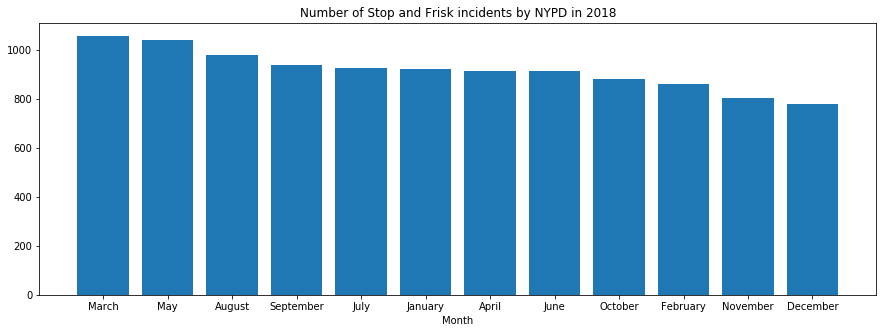

In [6]:
temp = sqf_df['MONTH2'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (15, 5))
ax.bar(temp.index, temp.values)
ax.set_title("Number of Stop and Frisk incidents by NYPD in 2018")
ax.set_xlabel("Month");

### Visualizing Race

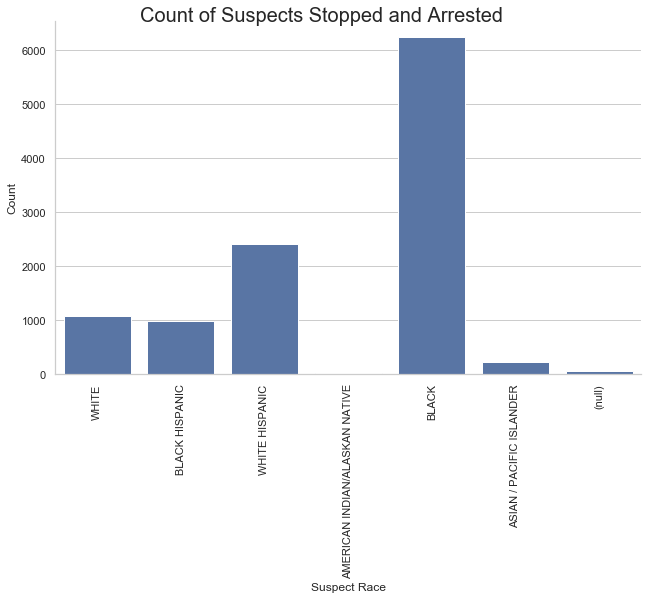

In [7]:
sqf_df['count'] = 1 # for color purpose later
sns.set(style="whitegrid")
# use hue='count' for one color
ax = sns.catplot(x="SUSPECT_RACE_DESCRIPTION", kind="count", data=sqf_df, hue="count", legend=False)
ax.fig.set_size_inches(10,6)
ax.set_axis_labels("Suspect Race", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)
ax.set_xticklabels(rotation = 90);

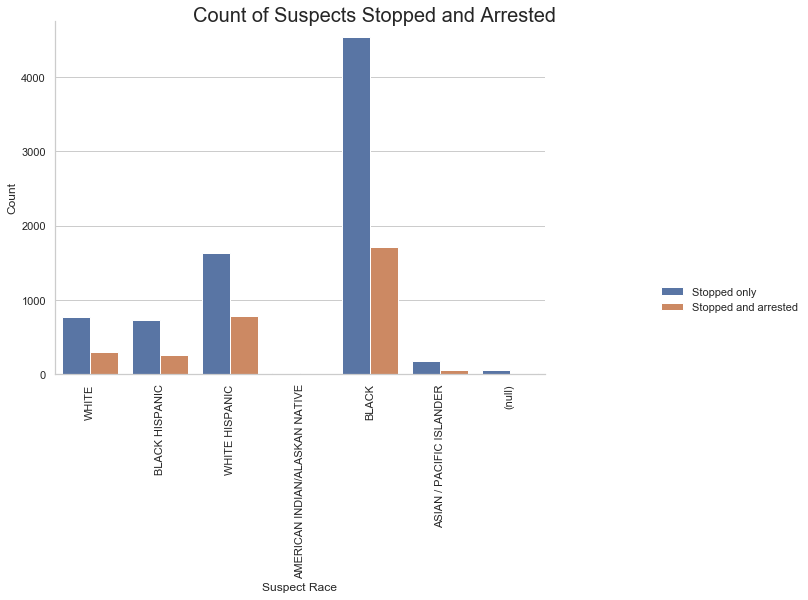

In [8]:
# temp = sqf_df['SUSPECT_RACE_DESCRIPTION'].value_counts()
sns.set(style="whitegrid")
ax = sns.catplot(x="SUSPECT_RACE_DESCRIPTION", hue="SUSPECT_ARRESTED_FLAG", kind="count", data=sqf_df)
ax.fig.set_size_inches(12,6)
ax.set_axis_labels("Suspect Race", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)

# title
ax._legend.set_title("")

# legend
new_labels = ['Stopped only', 'Stopped and arrested']
for t, l in zip(ax._legend.texts, new_labels): 
    t.set_text(l)
ax.set_xticklabels(rotation = 90);

### Visualizing Gender

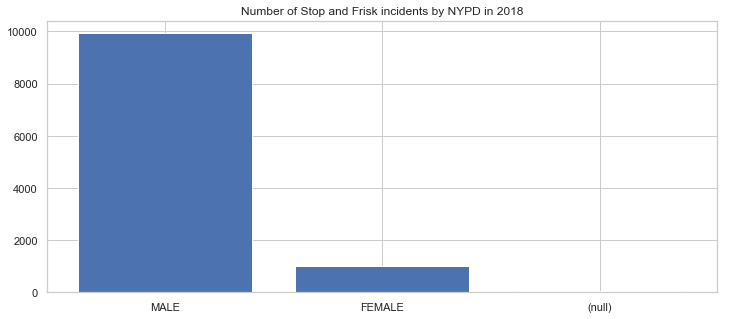

In [9]:
temp = sqf_df['SUSPECT_SEX'].value_counts()
fig, ax = plt.subplots(1,1, figsize = (12, 5))
ax.bar(temp.index, temp.values);
ax.set_title("Number of Stop and Frisk incidents by NYPD in 2018");

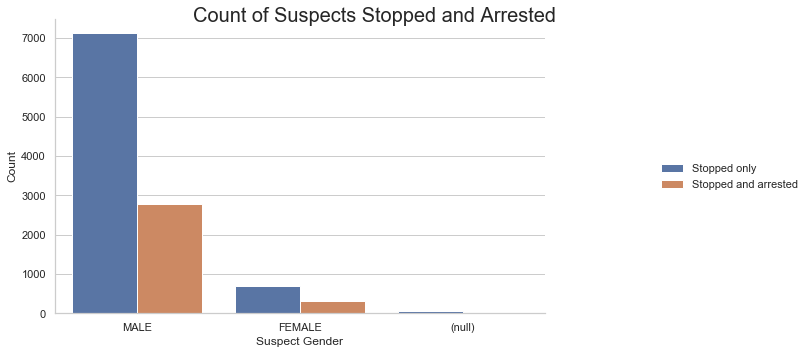

In [10]:
# temp = sqf_df['SUSPECT_RACE_DESCRIPTION'].value_counts()
sns.set(style="whitegrid")
ax = sns.catplot(x="SUSPECT_SEX", hue="SUSPECT_ARRESTED_FLAG", kind="count", data=sqf_df)
ax.fig.set_size_inches(12,5)
ax.set_axis_labels("Suspect Gender", "Count")
ax.fig.suptitle("Count of Suspects Stopped and Arrested", fontsize = 20)

# title
ax._legend.set_title("")

# legend
new_labels = ['Stopped only', 'Stopped and arrested']
for t, l in zip(ax._legend.texts, new_labels): 
    t.set_text(l);

### Visualizing Age

In [193]:
temp = dict(clean_sqf_df['SUSPECT_REPORTED_AGE'].value_counts())
keys = temp.keys()
values = [temp[k] for k in keys]
temp_age = pd.DataFrame({'age': list(keys), 'values': values})
temp_age['age'] = temp_age['age'].astype(int)
temp_age = temp_age.sort_values(by = "age")

age_group = clean_sqf_df[clean_sqf_df['SUSPECT_ARRESTED_FLAG']==1].groupby("SUSPECT_REPORTED_AGE")['SUSPECT_ARRESTED_FLAG'].value_counts()
age_group = pd.DataFrame(age_group)
dct = {age_group.index[k][0] : int(age_group.values[k]) for k in range(age_group.shape[0])}

norm_key = sorted(dct.keys())
norm_val = [dct[k] for k in norm_key]
temp_age2 = pd.DataFrame({'age': list(norm_key), 'values': norm_val})
temp_age2['age'] = temp_age2['age'].astype(int)
temp_age2 = temp_age2.sort_values(by = "age")


In [191]:
dct

{'10': 1,
 '11': 1,
 '12': 3,
 '13': 20,
 '14': 55,
 '15': 90,
 '16': 141,
 '17': 152,
 '18': 148,
 '19': 129,
 '20': 118,
 '21': 115,
 '22': 119,
 '23': 110,
 '24': 98,
 '25': 104,
 '26': 95,
 '27': 96,
 '28': 85,
 '29': 77,
 '30': 68,
 '31': 67,
 '32': 67,
 '33': 57,
 '34': 62,
 '35': 69,
 '36': 58,
 '37': 51,
 '38': 52,
 '39': 39,
 '40': 53,
 '41': 31,
 '42': 42,
 '43': 34,
 '44': 22,
 '45': 47,
 '46': 40,
 '47': 44,
 '48': 37,
 '49': 34,
 '50': 38,
 '51': 23,
 '52': 40,
 '53': 18,
 '54': 31,
 '55': 31,
 '56': 26,
 '57': 14,
 '58': 15,
 '59': 16,
 '60': 15,
 '61': 8,
 '62': 3,
 '63': 5,
 '64': 6,
 '65': 2,
 '66': 4,
 '67': 2,
 '68': 2,
 '69': 1,
 '70': 2,
 '73': 1,
 '74': 1,
 '76': 1,
 '77': 1}

In [192]:
temp_age

,age,values
56,0,8
73,1,1
71,2,1
69,5,1
63,10,2
57,11,7
52,12,17
41,13,76
20,14,201
11,15,351


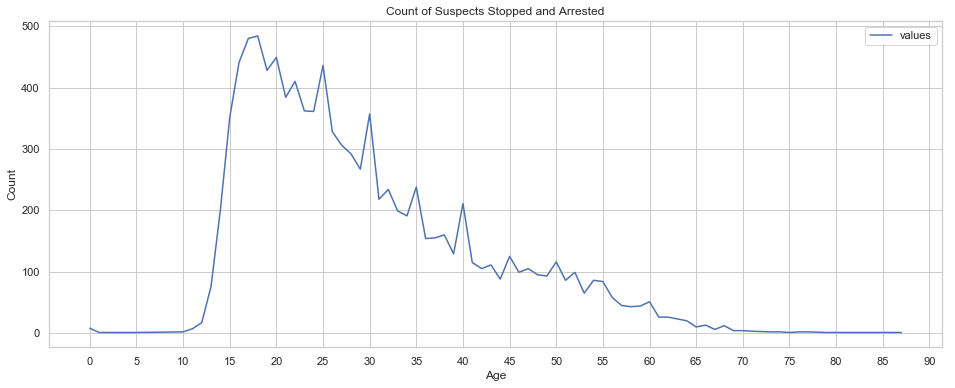

In [190]:
fig, ax = plt.subplots(1,1, figsize = (16, 6))
ax.set_xticks(range(0,100,5))
ax.plot(temp_age['age'], temp_age['values'])
# ax.plot(norm_key, norm_val, label = "Stopped and arrested")
ax.set_title("Count of Suspects Stopped and Arrested")
ax.set_xlabel("Age")
ax.set_ylabel("Count")
plt.legend()
plt.savefig('../viz/age.png', bbox_inches='tight');

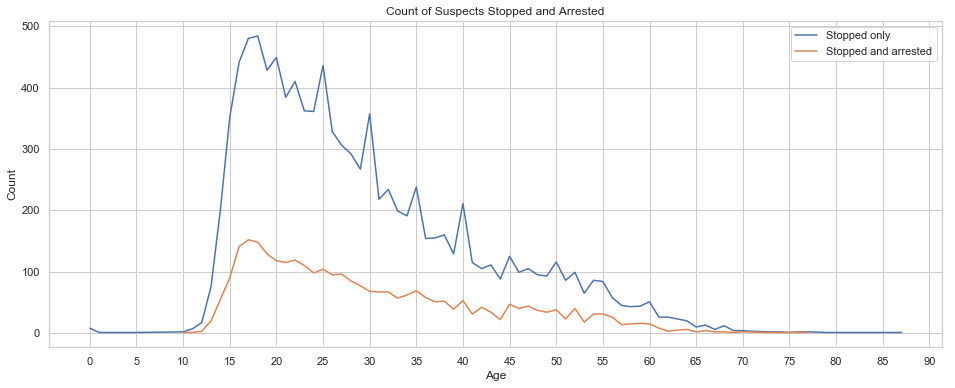

In [194]:
norm_key = sorted(dct.keys())
norm_val = [dct[k] for k in norm_key]

fig, ax = plt.subplots(1,1, figsize = (16, 6))
ax.set_xticks(range(0,100,5))
ax.plot(temp_age['age'], temp_age['values'], label = "Stopped only")
ax.plot(temp_age2['age'], temp_age2['values'], label = "Stopped and arrested")
ax.set_title("Count of Suspects Stopped and Arrested")
ax.set_xlabel("Age")
ax.set_ylabel("Count")
plt.legend()
plt.savefig('../viz/age2.png', bbox_inches='tight');

## Modeling

### Model 1: Random Forest Model Using Select Features

In [12]:
def top_k_features(features, feature_importances, k=10):
    indices = np.argsort(feature_importances)[-k:]
    return indices, features[indices], feature_importances[indices]

In [32]:
model_df = clean_sqf_df.select_dtypes(include=['int64', 'uint8', 'float64']).dropna(axis=0)
y = np.array(model_df['SUSPECT_ARRESTED_FLAG'])
X = model_df[model_df.columns.difference(['SUSPECT_ARRESTED_FLAG', 'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG'])]

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.33, random_state=42)

model_1 = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_1 = model_1.fit(X_train_full, y_train_full)

print(model_1.score(X_train_full, y_train_full))
print(model_1.score(X_test_full, y_test_full))

0.7358439077636786
0.7409972299168975


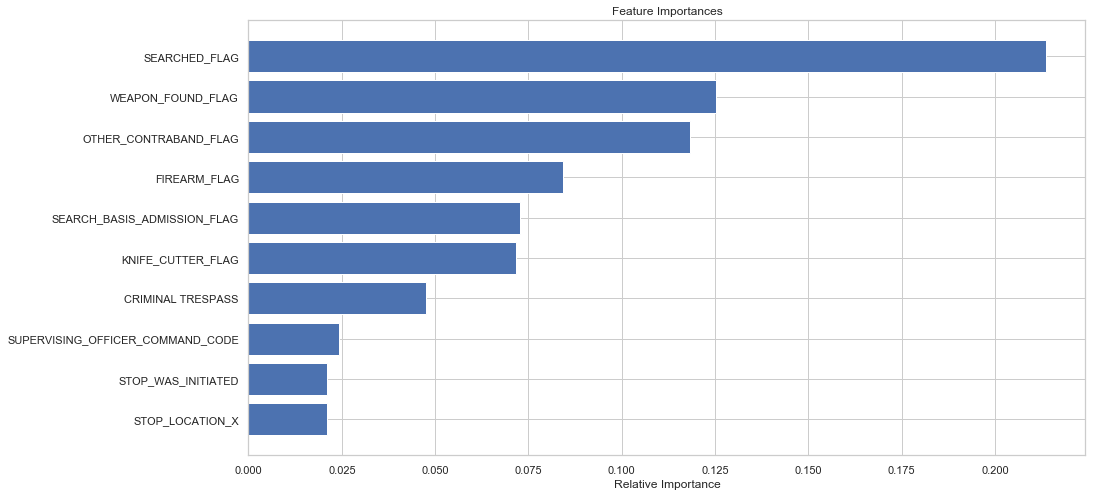

In [33]:
indices, features, importances = top_k_features(X_train_full.columns, model_1.feature_importances_, 10)

fig, ax = plt.subplots(figsize=(15,8))
ax.barh(range(len(indices)), importances, color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(features)
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

## Model 1b: Random Forest Model Using Fewer Features (Excluding unfair features)

In [ ]:
usable_cols = ['AUTO STRIPPIG',
               'BACKROUND_CIRCUMSTANCES_SUSPECT_KNOWN_TO_CARRY_WEAPON_FLAG',
#                'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG', 
               'BURGLARY', 
               'CPSP', 
#                'CPW', 
               'CRIMINAL MISCHIEF',
               'CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE',
               'CRIMINAL POSSESSION OF FORGED INSTRUMENT',
               'CRIMINAL POSSESSION OF MARIHUANA',
               'CRIMINAL SALE OF CONTROLLED SUBSTANCE', 
               'CRIMINAL SALE OF MARIHUANA',
               'CRIMINAL TRESPASS', 
               'FIREARM_FLAG', 
               'FORCIBLE TOUCHING',
#                'FRISKED_FLAG', 
               'GRAND LARCENY', 
               'GRAND LARCENY AUTO',
#                'ISSUING_OFFICER_COMMAND_CODE',
               'KNIFE_CUTTER_FLAG', 
               'MAKING GRAFFITI',  
#                'MENACING',
               'MURDER', 
#                'OBSERVED_DURATION_MINUTES',
               'OFFICER_EXPLAINED_STOP_FLAG', 
               'OFFICER_IN_UNIFORM_FLAG', 
               'OTHER',
               'OTHER_CONTRABAND_FLAG', 
               'OTHER_PERSON_STOPPED_FLAG',
               'OTHER_WEAPON_FLAG', 
               'PETIT LARCENY', 
               'PHYSICAL_FORCE_CEW_FLAG',
               'PHYSICAL_FORCE_DRAW_POINT_FIREARM_FLAG',
               'PHYSICAL_FORCE_HANDCUFF_SUSPECT_FLAG',
               'PHYSICAL_FORCE_OC_SPRAY_USED_FLAG', 
               'PHYSICAL_FORCE_OTHER_FLAG',
               'PHYSICAL_FORCE_RESTRAINT_USED_FLAG',
               'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG',
               'PHYSICAL_FORCE_WEAPON_IMPACT_FLAG', 
               'PROSTITUTION', 
               'RAPE',
               'RECKLESS ENDANGERMENT', 
               'ROBBERY', 
               'SEARCH_BASIS_ADMISSION_FLAG', 
               'SEARCH_BASIS_CONSENT_FLAG',
               'SEARCH_BASIS_HARD_OBJECT_FLAG', 
#                'SEARCH_BASIS_OTHER_FLAG',
               'SEARCH_BASIS_OUTLINE_FLAG', 
#                'STOP_DURATION_MINUTES', 
               'STOP_WAS_INITIATED',
#                'SUMMONS_ISSUED_FLAG', 
#                'SUPERVISING_OFFICER_COMMAND_CODE',
               'SUSPECTS_ACTIONS_CASING_FLAG',
               'SUSPECTS_ACTIONS_CONCEALED_POSSESSION_WEAPON_FLAG',
               'SUSPECTS_ACTIONS_DECRIPTION_FLAG',
               'SUSPECTS_ACTIONS_DRUG_TRANSACTIONS_FLAG',
               'SUSPECTS_ACTIONS_IDENTIFY_CRIME_PATTERN_FLAG',
               'SUSPECTS_ACTIONS_LOOKOUT_FLAG', 
               'SUSPECTS_ACTIONS_OTHER_FLAG',
               'SUSPECTS_ACTIONS_PROXIMITY_TO_SCENE_FLAG',  
               'TERRORISM',
               'THEFT OF SERVICES', 
               'UNAUTHORIZED USE OF A VEHICLE',               
#                'SEARCHED_FLAG',
               'WEAPON_FOUND_FLAG'
              ]

unusable_cols = ['WHITE', 
                 'WHITE HISPANIC', 
                 'SUSPECT_SEX',
                 'STOP_LOCATION_X',
                 'STOP_LOCATION_Y',
                 'STOP_LOCATION_PRECINCT',
                 'STATEN ISLAND',
                 'QUEENS',
                 'MONTH2',
                 'MANHATTAN',
                 'DAY2',
                 'BLACK', 
                 'BLACK HISPANIC',
                 'BROOKLYN', 
                 'ASIAN / PACIFIC ISLANDER',
                 'ID_CARD_IDENTIFIES_OFFICER_FLAG', 
                 'SHIELD_IDENTIFIES_OFFICER_FLAG'
                 'VERBAL_IDENTIFIES_OFFICER_FLAG'
                ]

In [58]:
model_df = clean_sqf_df.select_dtypes(include=['int64', 'uint8', 'float64']).dropna(axis=0)
y = np.array(model_df['SUSPECT_ARRESTED_FLAG'])
X = model_df[model_df.columns.difference(['SUSPECT_ARRESTED_FLAG', 'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG'])]
X_small = X[usable_cols].copy()

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_small, y, test_size=0.33, random_state=42)
print(X_train_sm.shape)

model_rf_fair = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model_rf_fair = model_rf_fair.fit(X_train_sm, y_train_sm)

print(model_rf_fair.score(X_train_sm, y_train_sm))
print(model_rf_fair.score(X_test_sm, y_test_sm))


(7329, 54)
0.7317505798881158
0.7365650969529086


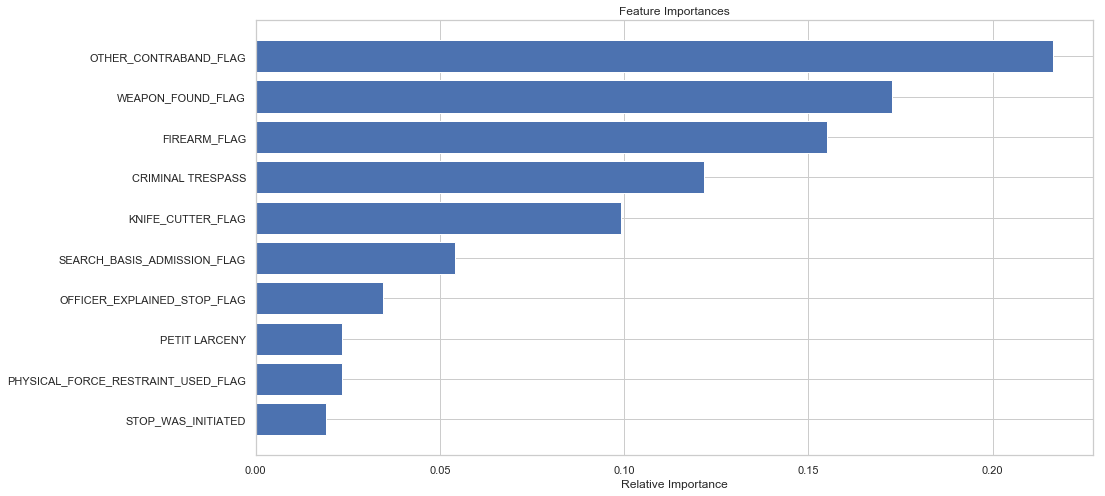

In [59]:
indices, features, importances = top_k_features(X_train_sm.columns, model_rf_fair.feature_importances_, 10)

fig, ax = plt.subplots(figsize=(15,8))
ax.barh(range(len(indices)), importances, color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(features)
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

### Model 2: AdaBoost

In [34]:
base = DecisionTreeClassifier(max_depth=2)
model_2 = AdaBoostClassifier(n_estimators=10, base_estimator=base).fit(X_train_full, y_train_full)

print(model_2.score(X_train_full, y_train_full))
print(model_2.score(X_test_full, y_test_full))

0.8841588211215718
0.8947368421052632


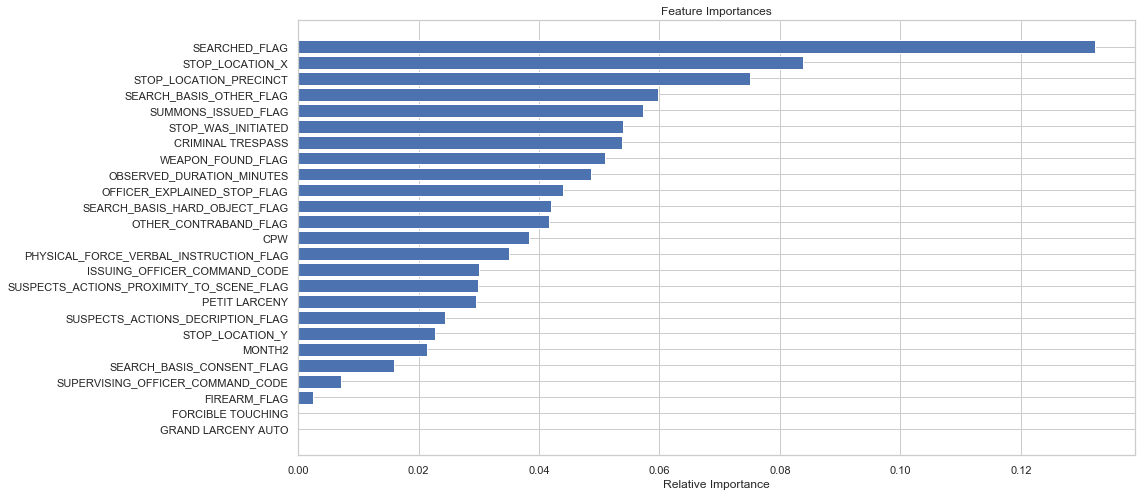

In [35]:
indices, features, importances = top_k_features(X_train_full.columns, model_2.feature_importances_, 25)

fig, ax = plt.subplots(figsize=(15,8))
ax.barh(range(len(indices)), importances, color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(features)
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

### Model 2b: Fair AdaBoost

In [36]:
# model_df = clean_sqf_df.select_dtypes(include=['int64', 'uint8', 'float64']).dropna(axis=0)
# y = np.array(model_df['SUSPECT_ARRESTED_FLAG'])
# X = model_df[model_df.columns.difference(['SUSPECT_ARRESTED_FLAG', 'SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG'])]
# X_small = X[usable_cols].copy()

# X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_small, y, test_size=0.33, random_state=42)
# print(X_train_sm.shape)

base = DecisionTreeClassifier(max_depth=2)
model_fair = AdaBoostClassifier(n_estimators=10, base_estimator=base).fit(X_train_sm, y_train_sm)

print(model_fair.score(X_train_sm, y_train_sm))
print(model_fair.score(X_test_sm, y_test_sm))

(7329, 54)
0.8025651521353527
0.7947368421052632


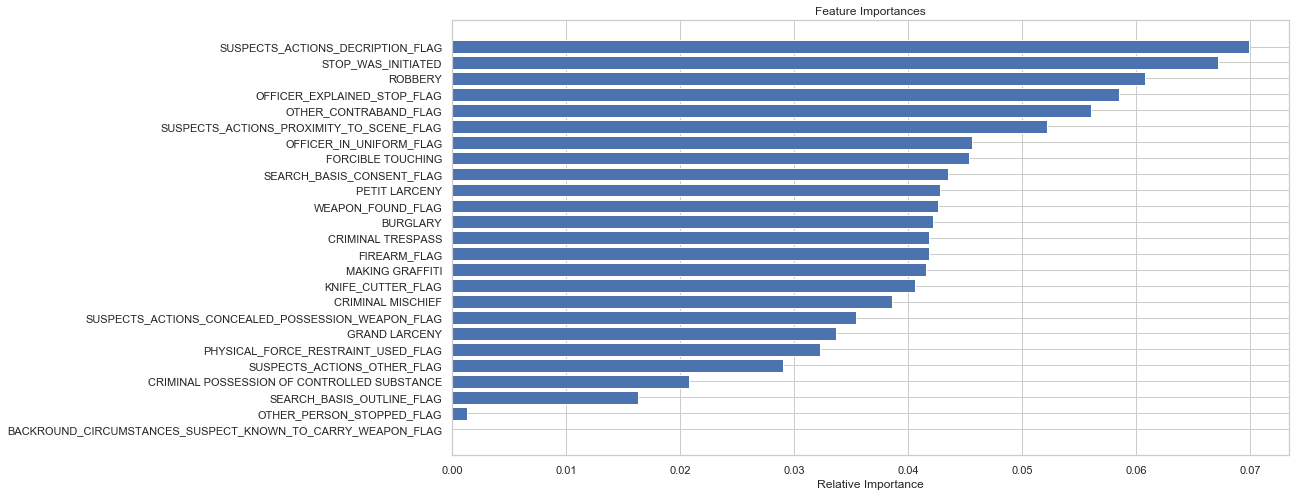

In [37]:
indices, features, importances = top_k_features(X_train_sm.columns, model_fair.feature_importances_, 25)

fig, ax = plt.subplots(figsize=(15,8))
ax.barh(range(len(indices)), importances, color='b', align='center')
ax.set_yticks(range(len(indices)))
ax.set_yticklabels(features)
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importances');

### Exploring Location

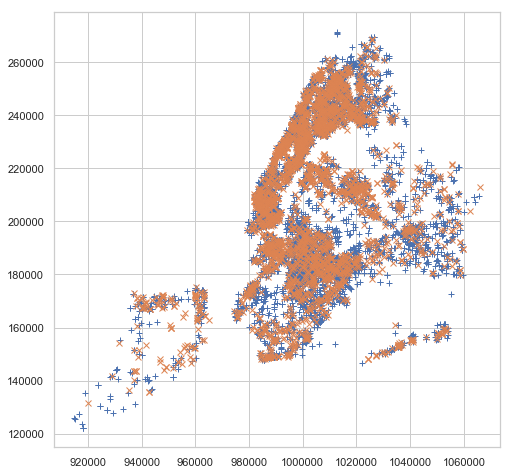

In [20]:
df_0 = model_df[model_df['SUSPECT_ARRESTED_FLAG'] == 0].copy()
df_1 = model_df[model_df['SUSPECT_ARRESTED_FLAG'] == 1].copy()
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_0['STOP_LOCATION_X'], df_0['STOP_LOCATION_Y'], '+', label='safe')
ax.plot(df_1['STOP_LOCATION_X'], df_1['STOP_LOCATION_Y'], 'x', label='arre')

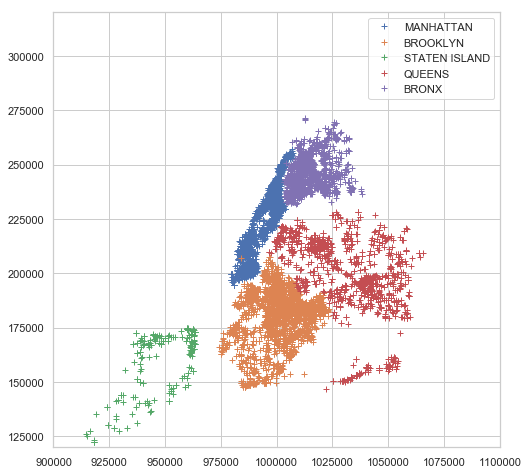

In [21]:
df = model_df[model_df['SUSPECT_ARRESTED_FLAG'] == 0].copy()
fig, ax = plt.subplots(figsize=(8,8))
boros = ['MANHATTAN', 'BRONX', 'BROOKLYN', 'STATEN ISLAND', 'QUEENS']

for boro in boros:
    if boro == 'BRONX':
        continue
    else:
        data = df[df[boro] == 1]
        ax.plot(data['STOP_LOCATION_X'], data['STOP_LOCATION_Y'], '+', label=boro)

# plotting Bronx
data = df[df['MANHATTAN'] + df['BROOKLYN'] + df['QUEENS'] + df['STATEN ISLAND'] == 0]
ax.plot(data['STOP_LOCATION_X'], data['STOP_LOCATION_Y'], '+', label='BRONX')

ax.legend()
ax.set_xlim(900000,1100000)
ax.set_ylim(120000, 320000);

In [22]:
df = sqf_df[sqf_df['SUSPECT_ARRESTED_FLAG'] == "Y"].copy()
boro_df = df.groupby(['STOP_LOCATION_BORO_NAME']).count()['STOP_FRISK_ID']

# population data = https://www.citypopulation.de/php/usa-newyorkcity.php
populations = {"BRONX": 1432132, "BROOKLYN": 2582830, "MANHATTAN": 1628701, "QUEENS": 2278906,
               "STATEN ISLAND": 476179}

norm_counts = {k:1000*v/populations[k] for k,v in zip(boro_df.index, boro_df)}
norm_counts

{'BRONX': 0.43711054567595725,
 'BROOKLYN': 0.35310105581861756,
 'MANHATTAN': 0.5532016005393255,
 'QUEENS': 0.24309910105989452,
 'STATEN ISLAND': 0.2562061745688071}

In [23]:
df = clean_sqf_df.copy()
precinct_df = df.groupby(['STOP_LOCATION_PRECINCT']).sum()['SUSPECT_ARRESTED_FLAG']
# precinct_df
df['STOP_LOCATION_X'].unique().shape

(6715,)

In [24]:
# clean_sqf_df[clean_sqf_df['FRISKED_FLAG'] + clean_sqf_df['SUSPECT_ARRESTED_FLAG'] == 2].shape
# clean_sqf_df[clean_sqf_df['SEARCHED_FLAG'] != clean_sqf_df['SUSPECT_ARRESTED_FLAG']].shape
clean_sqf_df[clean_sqf_df['SUSPECT_ARRESTED_FLAG'] == 1].shape
clean_sqf_df[clean_sqf_df['SEARCHED_FLAG'] + clean_sqf_df['SUSPECT_ARRESTED_FLAG'] == 2].shape

(2346, 111)

## Fairness Analysis

In [ ]:
model_1, model_rf_fair, model_2, model_fair

In [ ]:
thres = 0.5
predictions = model_1.predict(X_test_full) > thres
print('Statistical Parity of Gender:',
      evaluate_statistical_parity(predictions, 
                                  parity_df_test['SUSPECT_SEX'].values.astype(int) == 0))

---

## Statistical Parity

Statistical parity measures the difference between the probability of positive decisions for the protected group and the probability of positive decisions for the unprotected group. Mathematically:
$$Sp = P(d=1|G=0) - P(d=1|G=1)$$

Ideally, $Sp$ should be small such that there is little difference of probability of positive decisionb etween protected and unprotected group. A big value of $Sp$ suggests potential unfairness in the dataset and $Sp$ of 0 suggests complete fairness (equal probability).

In our dataset, we can examine the probability of positive decision (stopped and arrested) between different **gender** and **race**.

In gender, we are comparing the proportion of positive decisions amongst male and substracting the proportion of positive decisions amongst female

$$Sp = \frac{ \text{# people with positive decision and male}} { \text{ # of male} } - \frac{ \text{# people with positive decision and female}} { \text{ # of female}}$$

In [25]:
# Statistical parity function
def evaluate_statistical_parity(predictions, protected_class_array):
    """Function to calculate statistical parity.

     Parameters
    ----------
    predictions (numpy array): binary decision labels outputted by our trained model.
    protected_class_array (numpy array): boolean mask where protected rows are marked True.

    Returns
    -------
    bias (float): statistical parity bias 
    (difference between proportion of positive decisions of protected class and unprotected class)
    """
    prop_protected = np.sum(predictions & protected_class_array) / np.sum(protected_class_array)
    prop_not_protected = np.sum(predictions & ~protected_class_array) / np.sum(~protected_class_array)
    bias = np.abs(prop_protected - prop_not_protected)

    return bias

In [26]:
parity_df = deal_with_missing_values(sqf_df)
parity_df = convert_flags_to_boolean(parity_df)
parity_df = replace_with_map(parity_df, 'SUSPECT_SEX', {'MALE': 1, 'FEMALE': 0, np.nan: np.nan})
parity_df = replace_with_map(parity_df, 'SUSPECT_RACE_DESCRIPTION', {'BLACK': 1, 'WHITE': 0, 'WHITE HISPANIC': 2, 'BLACK HISPANIC': 2, 'ASIAN / PACIFIC ISLANDER':3, 'AMERICAN INDIAN/ALASKAN NATIVE':4, np.nan: np.nan})

In [27]:
parity_df['black_white'] = parity_df['SUSPECT_RACE_DESCRIPTION']
parity_df['black_white'][parity_df['black_white'] > 1] = np.nan


/Users/pwong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
test_inx = X_test_full.index
parity_df_test = parity_df.iloc[test_inx]

In [39]:
thres = 0.5
predictions = model_1.predict(X_test_full) > thres
len(predictions), X_test.shape

(3610, (3610, 54))

In [164]:
thres = 0.5
predictions = model_fair.predict(X_test_sm) > thres
print('Statistical Parity of Gender:',
      evaluate_statistical_parity(predictions, 
                                  parity_df_test['SUSPECT_SEX'].values.astype(int) == 0))
print('Statistical Parity on Black/White:',
      evaluate_statistical_parity(predictions, 
                                  parity_df_test['black_white'].values.astype(int) == 1))

print('Conditional Parity on test set, conditioned on people of race=1:', conditional_parity_orig)



Statistical Parity of Gender: 0.004477489930292372
Statistical Parity on Black/White: 0.0014591732732174845
Conditional Parity on test set, conditioned on people of race=1: 0.004354354354354354


In [40]:
# print('Statistical Parity of Gender:', evaluate_statistical_parity(parity_df['SUSPECT_ARRESTED_FLAG'].values, parity_df['SUSPECT_SEX'].values.astype(int)))
thres = 0.5
predictions = model_1.predict(X_test_full) > thres
print('Statistical Parity of Gender:',
      evaluate_statistical_parity(predictions, 
                                  parity_df_test['SUSPECT_SEX'].values.astype(int) == 0))
# Female is coded as 0
                            

Statistical Parity of Gender: 0.01705719296681084


Statistical parity shows perfect fairness when the indicator is 0. From the data, we see almost prefect fairness (with a statistical parity of .017) between the two genders that the proportion of decision on arresting is very similar between both genders.

In [ ]:
# print('Statistical Parity on Black/White:', evaluate_statistical_parity(parity_df['SUSPECT_ARRESTED_FLAG'].values, 
#                             parity_df['black_white'].values.astype(int)))
                            

In [41]:
thres = 0.5
predictions = model_1.predict(X_test_full) > thres
print('Statistical Parity on Black/White:',
      evaluate_statistical_parity(predictions, 
                                  parity_df_test['black_white'].values.astype(int) == 1))

print('Conditional Parity on test set, conditioned on people of race=1:', conditional_parity_orig)


# black is coded as 1
                            

Statistical Parity on Black/White: 0.0023591536920535595


Statistical parity shows perfect fairness when the indicator is 0. From the data, we see almost prefect fairness between white and non-white that the proportion of decision on arresting is very similar between both groups.

## Conditional Parity
We want to see what happens when we look at the subgroup corresponding to race=1. Are we being fair, in terms of statistical parity, in that subgroup? Our conditional vector is very simple in this case: it just corresponds to the `race` column in our dataset. Remember, however, that we're still looking at fairness in terms of gender; we're just observing a racial subgroup.

In [43]:
# Conditional parity function
def evaluate_conditional_parity(predictions, protected_class_array, condition_array):
        """Function to calculate Conditional statistical parity.
        
         Parameters
        ----------
        predictions (numpy array): binary (decision) labels for X
        protected_class_array (numpy array): boolean array where protected rows are marked True
        condition_array (numpy array): boolean array that indicates conditional status
        
        Returns
        -------
        bias (float): conditional parity bias
        """
        
        # --------------
        # --------------
        # Your code here
        # --------------
        # --------------
        
        
        prop_protected = np.sum(predictions & condition_array & protected_class_array) / np.sum(condition_array & protected_class_array)
        prop_not_protected = np.sum(predictions & condition_array & ~protected_class_array) / np.sum(condition_array & ~protected_class_array)
        bias = np.abs(prop_protected - prop_not_protected)
        return bias

In [44]:
# Observing statistical parity on test set
protected_class_array = parity_df_test['black_white'].values.astype(int) == 1
condition_array = parity_df_test['SUSPECT_SEX'].values.astype(int) == 0
conditional_parity_orig = evaluate_conditional_parity(predictions, protected_class_array, condition_array)

print('Conditional Parity on test set, conditioned on people of race=1:', conditional_parity_orig)


Conditional Parity on test set, conditioned on people of race=1: 0.004354354354354354


# False Positive (Negative) Error Rate Balance

The previous measures don't take into account the real labels of each observation; they only consider the predictions. The measure of fairness proposed here controls for equal poportions of false positives/false negatives in protected and unprotected classes. This measure is ideal in cases where committing mistakes disproportionately for different protected groups can bring negative outcomes.

We will again code these measures as they are rather easy to understand. The function definition below will guide you through the process.

In [45]:
# False positive and false negative rates
def evaluate_false_negative_rate(predictions, protected, y):
    """evaluate fnr

    Parameters
    ----------
    predictions (numpy array): binary (decision) labels for X predicted by our model
    protected (numpy array): boolean mask where protected rows are marked True or 1
    y (numpy array): boolean array that marks ground truth

    Note:
        FNR: FN / CP where FN=(predictions==0) & (y==1) CN = (y==1)

    Returns
    -------
    bias (float)
    """

    # --------------
    # --------------
    # Your code here
    # --------------
    # --------------
    
    cond_pos_protected = np.sum((y==1) & protected)
    cond_pos_not_protected = np.sum((y==1) & ~protected)
    
    if cond_pos_protected == 0:
        return 'No Condition Positive in Protected'
    if cond_pos_not_protected == 0:
        return 'No Condition Positive in Not Protected'

    false_neg_protected = np.sum((y==1) & (predictions==0) & protected)
    false_neg_not_protected = np.sum((y==1) & (predictions==0) & ~protected)

    fnr_g = false_neg_protected / cond_pos_protected
    fnr_not_g = false_neg_not_protected / cond_pos_not_protected
    bias = np.abs(fnr_g - fnr_not_g)
    
    return bias


def evaluate_false_positive_rate(predictions, protected, y):
    """evaluate fpr

    Parameters
    ----------
    predictions (numpy array): binary (decision) labels for X predicted by our model
    protected (numpy array): boolean mask where protected rows are marked True or 1
    y (numpy array): boolean array that marks ground truth

    Note:
        FPR: FP / CN where FP=(predictions==1) & (y==0) CN = (y==0)

    Returns
    -------
    bias (float)
    """

    # --------------
    # --------------
    # Your code here
    # --------------
    # --------------

    cond_neg_protected = np.sum((y==0) & protected)
    cond_neg_not_protected = np.sum((y==0) & ~protected)
    
    if cond_neg_protected == 0:
        return 'No Condition Negative in Protected'
    if cond_neg_not_protected == 0:
        return 'No Condition Negative in Not Protected'

    false_pos_protected = np.sum((y==0) & predictions & protected)
    false_pos_not_protected = np.sum((y==0) & predictions & ~protected)

    fpr_g = false_pos_protected / cond_neg_protected
    fpr_not_g = false_pos_not_protected / cond_neg_not_protected
    bias = np.abs(fpr_g - fpr_not_g)
    return bias


In [46]:
# Test FPR and FNR
protected_class_array = parity_df_test['SUSPECT_SEX'].values.astype(int) == 0
fpr = evaluate_false_positive_rate(predictions, protected_class_array, y_test)
fnr = evaluate_false_negative_rate(predictions, protected_class_array, y_test)

print('Difference in false positive rate between genders: ', fpr)
print('Difference in false negative rate between genders:', fnr)

Difference in false positive rate between genders:  0.0033585222502099076
Difference in false negative rate between genders: 0.05888888888888888


In [47]:
# Test FPR and FNR
protected_class_array = parity_df_test['black_white'].values.astype(int) == 1
fpr = evaluate_false_positive_rate(predictions, protected_class_array, y_test)
fnr = evaluate_false_negative_rate(predictions, protected_class_array, y_test)

print('Difference in false positive rate between black/white: ', fpr)
print('Difference in false negative rate between black/white:', fnr)

Difference in false positive rate between black/white:  0.0010191076620517671
Difference in false negative rate between black/white: 0.0003230090083623516


## Other Fairness metrics 

We have coded and tested some basic Fairness metrics, but there are multiple other metrics that can be used, depending on the situation. Some of them are:

**Predictive parity:**
The fraction of correct positive predictions should be the same for protected and unprotected groups.
$$P(Y=1|d=1, G=m) = P(Y=1|d=1, G=f)$$


**Equalized odds:**
Applicants with a good actual credit scope and applicants with a bad actual credit
score should have a similar classification, regardless of the value of the protected class.
$$P(d=1|Y=i, G=m) = P(d=1|Y=i, G=f), i\in \{0,1\}$$


**Overall accuracy equality:**
Both protected and unprotected groups have equal prediction accuracy.
$$P(d=Y, G=m) = P(d=Y, G=f)$$


**Treatment Equality:**
Looks at ratio of errors a classifier makes instead of its accuracy. Satisfied if both protected and unprotected groups have equal ratio of false negatives and false positives.


We will not go through all of them in code to save time. We will now try to generate a fair model.

## SHAP

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. 

SHAP assigns each feature an importance value for a particular prediction.

SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

In [97]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(X_train_full)

We then plot the SHAP values of every feature for every sample. The height of the bars shows the average impact of the features to model output (in magnitude). We see similar amount of contribution of features between the two classes. 

Unlikely the scikit-learn feature importance explanation, "STOP_LOCATION_X" is only listed as marginally important in SHAP value. 

The most important feature suggested by the SHAP value includes "SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG", "SEARCHED_FLAG", "OTHER_CONTRABAND_FLAG" and "WEAPON_FOUND_FLAG". It makes intuitive sense that weapon found on suspect and contraband found on suspect contribute to the predicted arrest decision. 

The data from NYPD unfortunately does not come with an informative data dictionary, therefore, we can only infer the meaning of the features from its name. We are uncertain about interpretation of some of the features, for example,  for all observations with "SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG" as 1, we expected "SEARCHED_FLAG" to also be 1 and vice versa, however, we only see 85% of observation share same values between the two features.

### Definition of SHAP value
$f_x(S) = f(h_x(z')) = E[f(x) | x_S]$

1. $z'$ represent a feature being observed ($z_i'$ = 1) or unknown ($z_i'$ = 0)

2. $h_x$ is a mapping that maps between a binary pattern of missing features represented by $z'$ and the original function input space.

Given such mapping, we can evaluate $f(h_x(z'))$ and so calculate the effect of observing ($z_i' = 1$) or not observing a feature ($z_i' = 0$)

3. $S$ refers the set of non-zero indexes in $z'$

4. $E[f(x) | x_S]$ is the expected value of the function conditioned on a subset $S$ of the input features.



SHAP values combine these conditional expectations with the classic Shapley values from game theory to attribute $\phi_i$ values to each feature:

$\phi_i = \sum \frac{|S|!(M-|S|-1)}{M!} [f_x(S \cup \{i\}) - f_x(S)]$

In [54]:
len(shap_values[0])

7329

In [50]:
explainer.expected_value[0]

0.7154755052179098

In [51]:
len(explainer.expected_value)

2

In [52]:
explainer.expected_value[1]

0.28452449128963053

In [69]:
# np.any(X_train_full.columns.values in X_train_sm.columns.values)

excl_col = X_train_full.columns.difference(X_train_sm.columns).values
excl_col

array(['ASIAN / PACIFIC ISLANDER',
       'BACKROUND_CIRCUMSTANCES_VIOLENT_CRIME_FLAG', 'BLACK',
       'BLACK HISPANIC', 'BROOKLYN', 'CPW', 'DAY2', 'FRISKED_FLAG',
       'ID_CARD_IDENTIFIES_OFFICER_FLAG', 'ISSUING_OFFICER_COMMAND_CODE',
       'MANHATTAN', 'MENACING', 'MONTH2', 'OBSERVED_DURATION_MINUTES',
       'QUEENS', 'SEARCHED_FLAG', 'SEARCH_BASIS_OTHER_FLAG',
       'SHIELD_IDENTIFIES_OFFICER_FLAG', 'STATEN ISLAND',
       'STOP_DURATION_MINUTES', 'STOP_LOCATION_PRECINCT',
       'STOP_LOCATION_X', 'STOP_LOCATION_Y', 'SUMMONS_ISSUED_FLAG',
       'SUPERVISING_OFFICER_COMMAND_CODE', 'SUSPECT_SEX',
       'VERBAL_IDENTIFIES_OFFICER_FLAG', 'WHITE', 'WHITE HISPANIC'],
      dtype=object)

In [100]:
%matplotlib

Using matplotlib backend: MacOSX


In [156]:
# load JS visualization code to notebook
# shap.initjs()
class_num = 0 # class
# i = 3233 # observation index
i = 3

shap.force_plot(explainer.expected_value[class_num], shap_values[class_num][i], feature_names=X_train_full.columns, show=False, text_rotation=60, matplotlib=True)
plt.title("SHAP value in 'Not Arrested' - Full model", {'fontsize': 16, "fontweight": 'bold'}, y = 1.5)
plt.savefig('shap_rf_full_class0.png', bbox_inches='tight')
# f = plt.gcf()
# plt.show(f)

In [157]:
# small model
explainer_rf_fair = shap.TreeExplainer(model_rf_fair)
shap_values_rf_fair = explainer.shap_values(X_train_sm)
shap.force_plot(explainer_rf_fair.expected_value[class_num], shap_values_rf_fair[class_num][i], feature_names=X_train_sm.columns, show=False, text_rotation=60, matplotlib=True)
plt.title("SHAP value in 'Not Arrested' - Adjusted model", {'fontsize': 16, "fontweight": 'bold'}, y = 1.5)
plt.savefig('shap_rf_sm_class0.png', bbox_inches='tight')


In [158]:
class_num = 1
shap.force_plot(explainer.expected_value[class_num], shap_values[class_num][i], feature_names=X_train_full.columns, show=False, text_rotation=60, matplotlib=True)
plt.title("SHAP value in 'Arrested' - Full model", {'fontsize': 16, "fontweight": 'bold'}, y = 1.5)
plt.savefig('shap_rf_full_class1.png', bbox_inches='tight')

In [159]:
# small model
class_num = 1
shap.force_plot(explainer_rf_fair.expected_value[class_num], shap_values_rf_fair[class_num][i], feature_names=X_train_sm.columns, show=False, text_rotation=60, matplotlib=True)
plt.title("SHAP value in 'Arrested' - Adjusted model", {'fontsize': 16, "fontweight": 'bold'}, y = 1.5)
plt.savefig('shap_rf_sm_class1.png', bbox_inches='tight')

shap.force_plot(explainer_rf_fair.expected_value[class_num], shap_values_rf_fair[class_num][i], feature_names=X_train_sm.columns)


In [72]:
model_1.predict_proba(X_train)

array([[0.79968041, 0.20031959],
       [0.80260262, 0.19739738],
       [0.61453531, 0.38546469],
       ...,
       [0.69593969, 0.30406031],
       [0.78578064, 0.21421936],
       [0.78967025, 0.21032975]])

In [87]:
temp_prob = model_1.predict_proba(X_train)
temp_prob[0] - temp_prob[1]

array([-0.00292221,  0.00292221])

In [97]:
temp_diff = np.array(list(map(lambda x: x[0] - x[1], temp_prob)))

In [101]:
np.argsort(np.abs(temp_diff))

array([ 732, 1506, 4487, ..., 3233, 6764, 4502])

In [100]:
temp_diff[np.argsort(np.abs(temp_diff))]

array([ 1.09764627e-04,  2.20680902e-04, -3.06442078e-04, ...,
        6.26243996e-01,  6.29163002e-01,  6.30215898e-01])

In [71]:
y_train.value_counts()/len(y_train)

0    0.714968
1    0.285032
Name: SUSPECT_ARRESTED_FLAG, dtype: float64

In [32]:
X_train['SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG'][X_train['SEARCHED_FLAG'] == 1].value_counts()

1    1419
0    1045
Name: SEARCH_BASIS_INCIDENTAL_TO_ARREST_FLAG, dtype: int64

In [43]:
X_train['MURDER'].value_counts()

0    7312
1      17
Name: MURDER, dtype: int64

In [134]:
shap.summary_plot(shap_values, X_train_full, show=True)
L = plt.legend()
L.get_texts()[0].set_text('Not Arrested')
L.get_texts()[1].set_text('Arrested')
plt.title("Mean SHAP value of Full Model")
plt.savefig('shap_full2.png', bbox_inches='tight')

In [135]:
shap.summary_plot(shap_values_rf_fair, X_train_sm, show=True)
L = plt.legend()
# L.get_texts()[0].set_text('Not Arrested')
# L.get_texts()[1]
L.get_texts()[0].set_text('Not Arrested')
L.get_texts()[1].set_text('Arrested')
plt.title("Mean SHAP value of Adjusted Model")
plt.savefig('shap_fair2.png', bbox_inches='tight')

In [ ]:
%matplolib.inline

---
## Visualize a RandomForest Tree

In [121]:
len(model_1.estimators_)

100

In [119]:
X_train.shape

(7329, 80)

In [117]:
# Extract single tree
estimator = model_1.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = X_train.columns,
#                 class_names = y_train,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
export_graphviz(estimator,out_file='tree2.dot',
                feature_names=X_train.columns,
                filled=True)


In [118]:
import pydot

(graph,) = pydot.graph_from_dot_file('tree2.dot')
graph.write_png('tree2.png')

---

## Reference

1. Lundberg, S.M., Erion, G.G. and Lee, S.I., 2018. Consistent individualized feature attribution for tree ensembles. arXiv preprint arXiv:1802.03888.